In [1]:
# importing all the required libraries.

import time
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from selenium import webdriver
from datetime import datetime, timedelta
from bs4 import BeautifulSoup as bs
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import StaleElementReferenceException

In [2]:
# Defining different functions for performing certain actions to avoid repititive code as they care called multiple times.
# All the functions below are documented individually.

def getChromeWindow(url):
    """
    This function is used to open the chrome window and go to the desired website.
    :param url: URL of the website you want to open.
    :return driver: Driver handle of the chrome window.
    """
    driver = webdriver.Chrome(executable_path = 'E:\Coding Ninjas Data Science\Lecture 20 - Web Browsing Selenium\chromedriver.exe')
    driver.get(url)
    driver.maximize_window()
    return driver
    
def loginToInstagram(driver, username, password):
    """
    This function is used to login into the desired instagram account and to avoid notifications.
    :param username: Username of the Instagram account .
    :param password: Password of the Instagram account.
    :param driver: Driver of the Instagram handle.
    """
    username_box = driver.find_element_by_name('username')
    password_box = driver.find_element_by_name('password')
    username_box.send_keys(username)
    password_box.send_keys(password)
    login = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//button[@class = "sqdOP  L3NKy   y3zKF     "]')))
    login.submit()
    login_info = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//div[@class = 'cmbtv']/button")))
    login_info.click()
    notification = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//button[@class = 'aOOlW   HoLwm ']")))
    notification.click()
        
def searchAndGetTopHandles(driver, keyword):
    """
    This function is used to get the list of top 10 accounts from the drop down after typing the word in the search box.
    :param keyword: Word to be used.
    :param driver: Driver of the chrome window.
    :return final: List of containing usernames of top 10 accounts.
    """
    search = driver.find_element_by_xpath('//input[@placeholder = "Search"]')
    search.send_keys(keyword)
    waiter = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "Ap253")))
    drp_dwn = driver.find_elements_by_class_name('yCE8d  ')
    final = []
    for account in drp_dwn:
        if account.get_attribute('href').find('https://www.instagram.com/explore/locations/') == -1 and account.get_attribute('href').find('https://www.instagram.com/explore/tags') == -1:
            name = account.find_element_by_class_name('Ap253').text
            final.append(name)
        if len(final) == 10:
            break
    return final[:10]

def searchAndOpenProfile(driver, keyword, acc_href):
    """
    This function is used to search for a profile using the search box and opening the account.
    :param keyword: Word to be searched in the search box.
    :param acc_href: This is the hyperlink to the desired account. This is generally same as the username of the account.
    :param driver: Driver of the chrome window.
    """
    try:
        clear_btn = driver.find_element_by_class_name('aIYm8')
        clear_btn.click()
        search = driver.find_element_by_xpath('//input[@placeholder = "Search"]')
        search.send_keys(keyword)
        acc = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//a[@href="/{}/"]'.format(acc_href))))
        acc.click()
    except NoSuchElementException:
        search = driver.find_element_by_xpath('//input[@placeholder = "Search"]')
        search.send_keys(keyword)
        wait = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//div[@class = 'drKGC']")))
        acc = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//a[@href="/{}/"]'.format(acc_href))))
        acc.click()

def getNumberOfFollowers(driver):
    """
    This function return the total number of followers for an account as integer.
    :param driver: Driver of the chrome window.
    """
    return int(driver.find_element_by_xpath("//a[@class = '-nal3 ']/span").get_attribute('title').replace(',',''))

def getNumberofPosts(driver, days):
    """
    This account is used to get the total number of posts done by an account for a few past days.
    :param driver: Driver of the chrome window.
    :param days: This defines for how many last days this function will get the posts. For example, for 3, this function will return the number of posts in last 3 days.
    :return : Total number of posts for last n days.
    """
    first_post = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//div[@class = 'v1Nh3 kIKUG  _bz0w']")))
    first_post.click()
    date = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "time")))
    date = date.get_attribute('datetime')
    date = date.replace(re.search('T.*Z', date).group(),'')
    date = (datetime.strptime(date, "%Y-%m-%d")).date()
    req_date = (datetime.today() - timedelta(days)).date()
    count = 0
    while date >= req_date:
        count += 1
        next_btn = driver.find_element_by_xpath("//a[@class = ' _65Bje  coreSpriteRightPaginationArrow']")
        next_btn.click()
        date = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "time")))
        date = date.get_attribute('datetime')
        date = date.replace(re.search('T.*Z', date).group(),'')
        date = (datetime.strptime(date, "%Y-%m-%d")).date()
    li = driver.find_elements_by_class_name('wpO6b ')
    close_btn = li[len(li)-1]
    close_btn.click()
    return count
    
def extractPostContent(driver, num):
    """
    This function is used to extract the caption(content) for the last n posts.
    :param num: This defines the number of posts for which we need to extract the content.
    :param driver: Driver of the chrome window.
    :return final: List of string containing content for the posts.
    """
    first_post = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//div[@class = 'v1Nh3 kIKUG  _bz0w']")))
    first_post.click()
    final = []
    content = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "C4VMK")))
    final.append(content.get_attribute('textContent'))
    count = 1
    while count < num:
        next_btn = driver.find_element_by_xpath("//a[@class = ' _65Bje  coreSpriteRightPaginationArrow']")
        next_btn.click()
        content = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "C4VMK")))
        final.append(content.get_attribute('textContent'))
        count += 1
    li = driver.find_elements_by_class_name('wpO6b ')
    close_btn = li[len(li)-1]
    close_btn.click()
    return final

def getNumberOfLikes(driver, num):
    """
    This function is used to calculate the total number of likes for picture posts and total number of views for video posts.
    :param num: Total number of posts for which we need to calculate total likes.
    :param driver: Driver of the chrome window.
    :return num_likes: Total number of likes calculated.
    """
    first_post = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//div[@class = 'v1Nh3 kIKUG  _bz0w']")))
    first_post.click()
    try:
        likes = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, "//div[@class = 'Nm9Fw']/button/span")))
        num_likes = int(likes.text.replace(',',''))
    except TimeoutException:
        likes = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, '//div[contains(@class, "HbPOm")]/span[contains(@class, "vcOH2")]/span')))
        num_likes = int(likes.text.replace(',',''))
    count = 1
    while count < num:
        next_btn = driver.find_element_by_xpath("//a[@class = ' _65Bje  coreSpriteRightPaginationArrow']")
        next_btn.click()
        try:
            likes = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, "//div[@class = 'Nm9Fw']/button/span")))
            num_likes += int(likes.text.replace(',',''))
        except TimeoutException:
            likes = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, '//div[contains(@class, "HbPOm")]/span[contains(@class, "vcOH2")]/span')))
            num_likes += int(likes.text.replace(',',''))
        count += 1
    li = driver.find_elements_by_class_name('wpO6b ')
    close_btn = li[len(li)-1]
    close_btn.click()
    return num_likes
        

In [8]:
# Open chrome and login to instagram. Replace <SAMPLE USERNAME> and <SAMPLE PASSWORD> witht the actual username and passowrd 
# of the account you want to login into.

driver = getChromeWindow('https://www.instagram.com/')
loginToInstagram(driver, 'anu_97_', 'Incorrect@1997')

### Question 1

1. Now your friend has followed a lot of different food bloggers, he needs to analyse the habits of these bloggers.

    1. From the list of instagram handles you obtained when you searched ‘food’ in previous project. Open the first 10 handles and find the top 5 which have the highest number of followers
    2. Now Find the number of posts these handles have done in the previous 3 days.
    3. Depict this information using a suitable graph.


In [206]:
# Typing food in the search button and getting the list of top 10 handles.

tophandles = searchAndGetTopHandles(driver, 'food')
tophandles

['thaparfoodfestival',
 'food2roam',
 'food_era_',
 'yourfoodlab',
 'just.went.for.food',
 'street_food_chandigarh',
 'food',
 'foodys',
 'delhifoodwalks',
 'foodnetwork']

In [207]:
# Getting the list of total followers and number of posts in the last 3 dyas for each of the handles above.
# Getting the followers and posts for handles simultaneously just to avoid repititive action to open profiles again.

number_of_followers = []
number_of_posts = []
for handle in tophandles:
    searchAndOpenProfile(driver, handle, handle)
    time.sleep(2)
    number_of_followers.append(getNumberOfFollowers(driver))
    time.sleep(1)
    number_of_posts.append(getNumberofPosts(driver, 3))
    
print(number_of_followers)
print(number_of_posts)

[2452, 367, 14306, 1508944, 4210, 83730, 100707, 8901211, 130957, 10900625]
[0, 0, 5, 4, 1, 7, 5, 10, 4, 32]


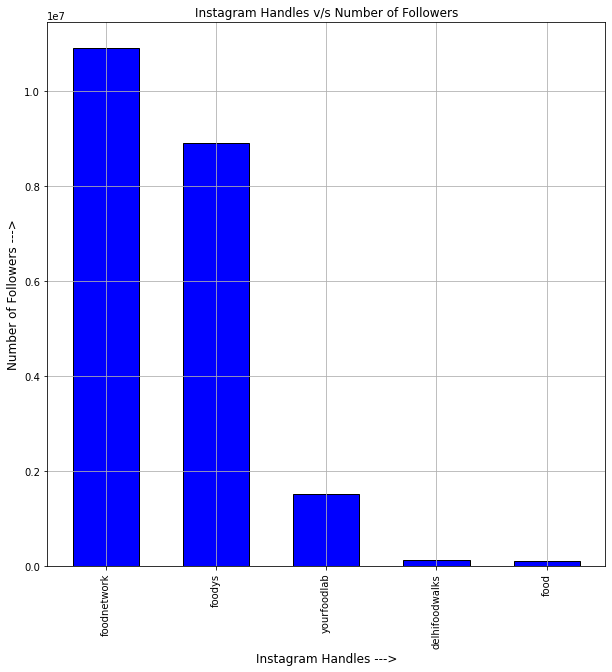

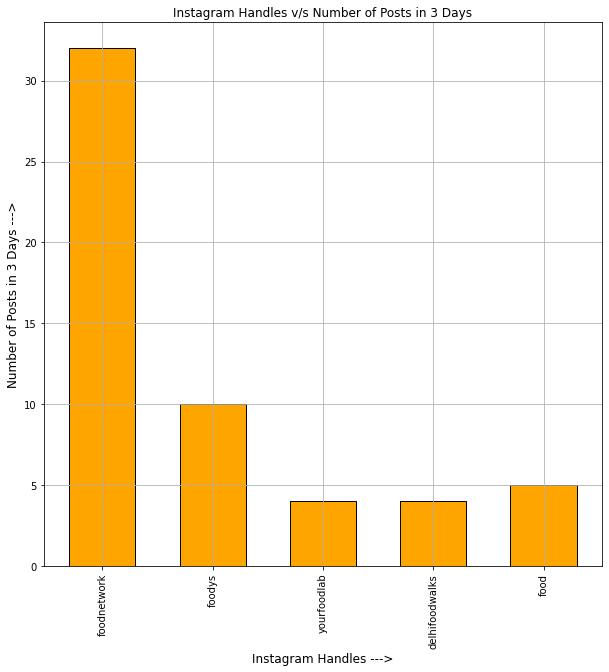

In [208]:
# Sorting the handles above on the basis of number of followers and selectiong the top handles, their followers and posts in the last 3 days.
# Plotting two bar graphs as mentioned below:
# 1. Instagram handles v/s their followers.
# 2. Instagram handles v/s posts in 3 days.

np_handles = np.array(tophandles)
np_followers = np.array(number_of_followers)
np_posts = np.array(number_of_posts)

np_handles = np_handles[np.argsort(np_followers)]
np_posts = np_posts[np.argsort(np_followers)]
np_followers = np.sort(np_followers)

np_handles = np_handles[::-1]
np_posts = np_posts[::-1]
np_followers = np_followers[::-1]

np_top5handles = np_handles[:5]
np_top5posts = np_posts[:5]
np_top5followers = np_followers[:5]

plt.figure(figsize = (10, 10))
plt.bar(np_top5handles, np_top5followers, color = 'blue', edgecolor = 'black', width = 0.6)
plt.xticks(rotation = 'vertical')
plt.xlabel("Instagram Handles --->", size = 12)
plt.ylabel("Number of Followers --->", size = 12)
plt.title("Instagram Handles v/s Number of Followers", size = 12)
plt.grid()
plt.show()

plt.figure(figsize = (10, 10))
plt.bar(np_top5handles, np_top5posts, color = 'orange', edgecolor = 'black', width = 0.6)
plt.xticks(rotation = 'vertical')
plt.xlabel("Instagram Handles --->", size = 12)
plt.ylabel("Number of Posts in 3 Days --->", size = 12)
plt.title("Instagram Handles v/s Number of Posts in 3 Days", size = 12)
plt.grid()
plt.show()

### Question 2

2. Your friend also needs a list of hashtags that he should use in his posts.

    1. Open the 5 handles you obtained in the last question, and scrape the content of the first 10 posts of each handle.
    2. Prepare a list of all words used in all the scraped posts and calculate the frequency of each word.
    3. Create a csv file with two columns : the word and its frequency
    4. Now, find the hashtags that were most popular among these bloggers
    5. Plot a Pie Chart of the top 5 hashtags obtained and the number of times they were used by these bloggers in the scraped posts.


In [211]:
# Looping over the top handles above and collecting the content of the first 10 posts for each handle.
driver.find_element_by_xpath("//a[@href = '/']").click()
contents = []
for handle in np_top5handles:
    searchAndOpenProfile(driver, handle, handle)
    contents.append(extractPostContent(driver, 10))


In [212]:
# Looping over each word from the contents and creating two dictionary for frequency as mentioned below.
# 1. For all the words as mentioned in the question irrespective of hastags or mentions.
# 2. For all the hashtags mentioned in the contents to record the frequency for each hashtag.

words_dict = defaultdict(int)
hashtags = defaultdict(int)

for item in contents:
    for content in item:
        print("-------------------")
        print(content)
        for word in content.split(' '):
            if word != '':
                words_dict[word] += 1
                if word[0] == '#':
                    hashtags[word] += 1

-------------------
foodnetworkVerifiedGlazed Bazon (with @sunnyanderson) 🥓🥓As far as we're concerned, this whole WEEK is still part of ~ the holidays ~ so excuse us while we indulge in @sunnyanderson's glazed bacon!#TheKitchen, Saturdays at 11a|10cSave the recipe: http://foodtv.com/3nGa8xt (Head to our IGTV for the clickable link!)7h
-------------------
foodnetworkVerifiedTwelve kid bakers enter the kitchen to battle it out for a spot in @foodnetworkmag and a $25,000 grand prize! For their first challenge, @DuffGoldman & @WolfiesMom embrace the brushstroke decorating trend by asking the bakers to create colorful and delicious brushstroke mini cheesecakes. A special two hour premiere of #KidsBakingChampionship is up NEXT at 9|8c! 🥳9h
-------------------
foodnetworkVerifiedHow to Make @geoffreyzakarian's Charred Brussels Sprouts with Bacon & Maple@geoffreyzakarian fries his sprouts in bacon fat before finishing them in the oven and tossing them in maple, mustard, chives and bacon! #TheK

In [213]:
# Printing frequency dict for hashtags and words_dict

print(hashtags)
print(words_dict)

defaultdict(<class 'int'>, {'#KidsBakingChampionship': 2, '#TheKitchen,': 1, '#discoveryplus': 2, '#Cakealikes': 1, '#Supermarket': 1, '#VivsTips!Watch': 1, '#foodys11h': 1, '#foodys2d': 1, '#foodie': 7, '#chicken': 2, '#chickenrecipes': 1, '#chicken65': 1, '#chickendinner': 1, '#mumbai': 1, '#chickensofinstagram': 1, '#chickendry': 1, '#sanjyotkeer21h': 1, '#foodporn': 9, '#foodstagram': 4, '#foodphotography': 3, '#foodstylist': 4, '#foodiesofinstagram1d': 1, '#food': 8, '#streetfood': 4, '#mumbaifoodie': 1, '#mumbaistreetfood': 1, '#indian': 1, '#fusionfood': 2, '#streetsofindia': 1, '#sanjyotkeer1d': 1, '#foodiesofinstagram2d': 1, '#MorphyRichardsChristmas': 1, '#ultimatechristmaschallenge4.': 1, '#foodiesofinstagram': 1, '#frankie': 1, '#sanjyotkeer5d': 1, '#gajarkahalwa': 2, '#gajarhalwa': 2, '#winteriscoming': 2, '#winterfood': 2, '#dessert': 2, '#dessertsofinstagram': 2, '#sanjyotkeer': 2, '#dessertlover1w': 2, '#indiancuisine': 1, '#streetphotography': 1, '#videography': 1, '#f

In [214]:
# Creating a pandas DataFrame for for the all words frequency dictionary and storing it in a csv file 'WordCount.csv'

words = []
frequency = []
for key, value in words_dict.items():
    words.append(key)
    frequency.append(value)
  
df = pd.DataFrame(columns=['Words', 'Frequency'])
df['Words'] = words
df['Frequency'] = frequency
df.to_csv('WordCount.csv')

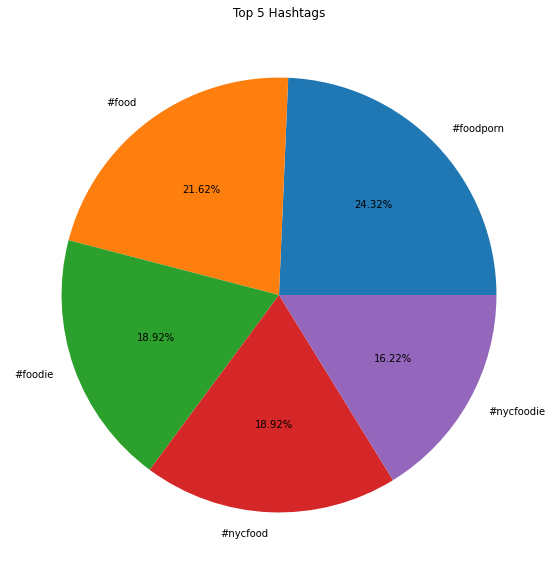

Frequency for Top 5 Hashtags:
#foodporn ---> 9
#food ---> 8
#foodie ---> 7
#nycfood ---> 7
#nycfoodie ---> 6


In [215]:
# Sorting the hashtags on the basis of frequency and selecting the top from the reversed list to get the most used 5 hashtags
# and plotting the pie chart for the same.

np_hashtags = np.array([key for key in hashtags])
np_frequency = np.array([value for key, value in hashtags.items()])

np_hashtags = np_hashtags[np.argsort(np_frequency)]
np_frequency = np.sort(np_frequency)

np_hashtags = np_hashtags[::-1]
np_frequency = np_frequency[::-1]

np_top5hashtags = np_hashtags[:5]
np_top5frequency = np_frequency[:5]

plt.figure(figsize=(10, 10))
plt.pie(np_top5frequency, labels = np_top5hashtags, autopct="%.2f%%")
plt.title("Top 5 Hashtags", size=12)
plt.show()

print("Frequency for Top 5 Hashtags:")
for i in range(5):
    print(np_top5hashtags[i], '--->', np_top5frequency[i])


### Question 3 

3. You need to also calculate average followers : likes ratio for the obtained handles.
Followers : Likes ratio is calculated as follows:

    1. Find out the likes of the top 10 posts of the 5 handles obtained earlier.
    2. Calculate the average likes for a handle.
    3. Divide the average likes obtained from the number of followers of the handle to get the average followers:like ratio of each handle.
    4. Create a bar graph to depict the above obtained information.


In [216]:
# Looping over the top 5 handles from the first question and counting the likes for video posts and views for the video posts
# from the first 10 posts of each handle.

likes = []
for handle in np_top5handles:
    searchAndOpenProfile(driver, handle, handle)
    likes.append(getNumberOfLikes(driver, 10))


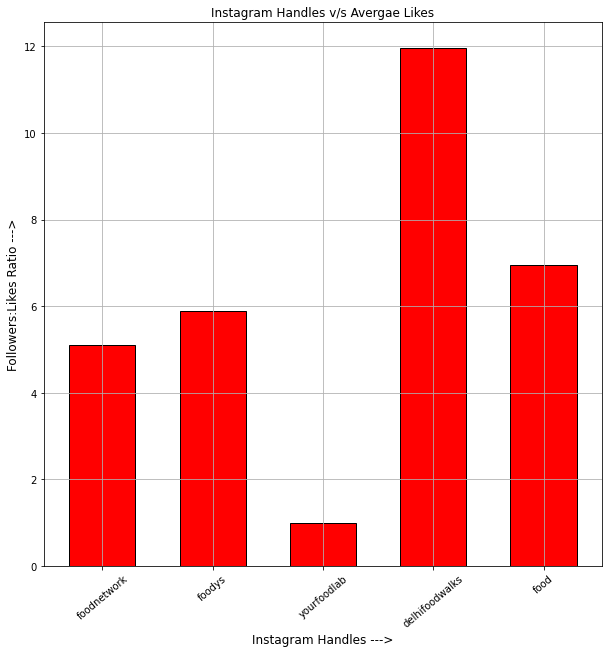

Top 5 Handles and their Average Likes:
foodnetwork ---> 5.108337406491153
foodys ---> 5.881054349406028
yourfoodlab ---> 0.9835277431600244
delhifoodwalks ---> 11.95408489274304
food ---> 6.951062948647157


In [217]:
# Calculating the Average likes for each handle as mentioned in the question and plotting the bar graph for the same.

ratios = np_top5followers/likes

plt.figure(figsize=(10,10))
plt.grid()
plt.bar(np_top5handles, ratios, color = 'red', edgecolor = 'black', width = 0.6)
plt.xlabel('Instagram Handles --->', size = 12)
plt.ylabel('Followers:Likes Ratio --->', size = 12)
plt.title('Instagram Handles v/s Avergae Likes', size = 12)
plt.xticks(rotation = 40)
plt.show()

print("Top 5 Handles and their Average Likes:")
for i in range(5):
    print(np_top5handles[i], '--->', ratios[i])